<h1>LSTM Model</h1>
<p>Test für ein LSTM mit einer kleinen Stichprobe </p>

In [128]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

<h2> 1. Preparing the Data </h2>

In [202]:
path = "../IDMT-Traffic/datasets/df_main.csv"
data = pd.read_csv(path) #data cleaning -> welche Daten nehmen wir, welche nicht? 

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.drop(["sample_pos"], axis=1, inplace=True)  
data["speed_kmh"]= data["speed_kmh"].replace('UNK', np.nan)
data["speed_kmh"] = pd.to_numeric(data["speed_kmh"], errors="coerce")
data.dropna(inplace=True)  

# Verify no NaN values remain
print(data.isnull().values.any()) 

False


/var/folders/xt/qp4h10d92h76_sfj0rh4m3v00000gn/T/ipykernel_32088/4151575388.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path) #data cleaning -> welche Daten nehmen wir, welche nicht?


In [203]:
print(data.isnull().values.any())
print(data.isin([np.inf, -np.inf]).any())#check if there are any inf values 

False
Unnamed: 0         False
file               False
is_background      False
date_time          False
location           False
                   ...  
peak_dB_2          False
peak_freq_2        False
peak_dB_3          False
peak_freq_3        False
octband_dB_mean    False
Length: 61, dtype: bool


<h3> 1.1 Encoding </h3

In [204]:
#all features of type binary/ categorical should be encoded as a numerical value
le = LabelEncoder()

for col in data.columns:
    if (data[col].dtype == "object" or data[col].dtype == "bool") and not (col == "file" or col == "speed_kmh"):
        #encode column and save in new column
        encoded_col = le.fit_transform(data[col])
        # add _encoded to the original column name
        new_col_name = col + "_encoded"
        # insert encoded column after the original one 
        col_index = data.columns.get_loc(col) + 1
        data.insert(col_index, new_col_name, encoded_col)

data.to_csv("../IDMT-Traffic/datasets/df_main_encoded.csv", index=False)


In [205]:
# Find all columns that have "_encoded" versions
encoded_columns = [col for col in data.columns if '_encoded' in col]

# Derive the base names of the encoded columns
base_columns_to_drop = [col.replace('_encoded', '') for col in encoded_columns]

# Drop the base columns that have "_encoded" counterparts
data = data.drop(columns=base_columns_to_drop)
data = data.drop(columns=["file"])

<h3> 1.2 Feature Selection </h3>

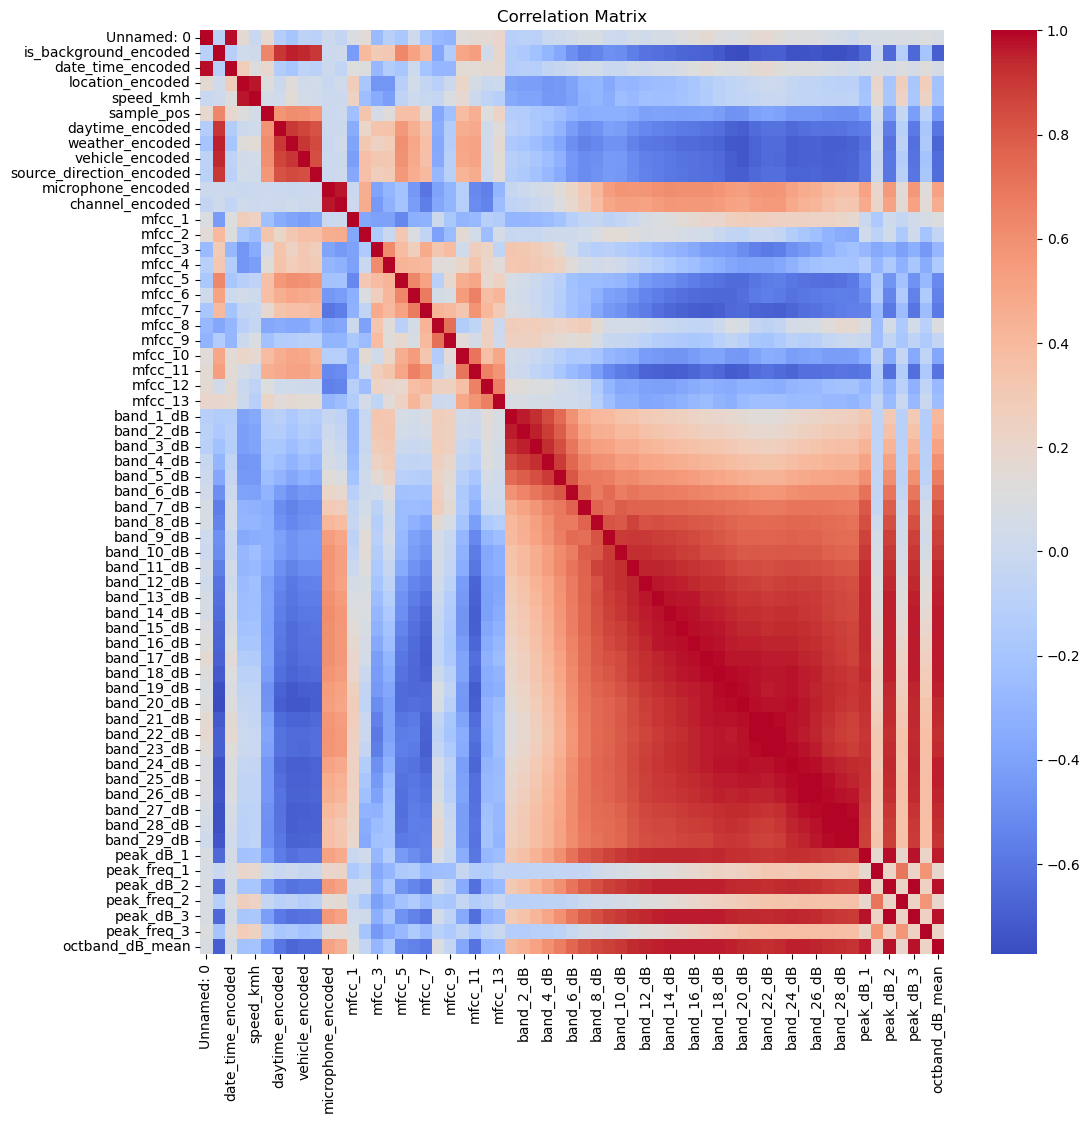

                       Unnamed: 0  is_background_encoded  date_time_encoded  \
Unnamed: 0               1.000000              -0.103313           0.979733   
is_background_encoded   -0.103313               1.000000          -0.110856   
date_time_encoded        0.979733              -0.110856           1.000000   
location_encoded         0.156445               0.028491           0.266474   
speed_kmh               -0.016334               0.019666           0.116163   
...                           ...                    ...                ...   
peak_dB_2                0.074637              -0.652531           0.062616   
peak_freq_2              0.079312              -0.115341           0.098736   
peak_dB_3                0.075940              -0.659665           0.064862   
peak_freq_3              0.103114              -0.202842           0.124016   
octband_dB_mean          0.073384              -0.697452           0.061046   

                       location_encoded  speed_kmh 

In [62]:
corr_matrix = data.corr()
fig = plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

print(corr_matrix)

In [112]:
#Drop Features that are highly correlated
threshold = 0.9
# Find pairs of features with correlation higher than the threshold
high_corr_pairs = np.where((abs(corr_matrix) > threshold) & (corr_matrix != 1))

# Extract unique pairs
pairs_to_check = [(corr_matrix.index[x], corr_matrix.columns[y]) 
                  for x, y in zip(*high_corr_pairs) if x < y]

# drop 
features_to_drop = set()

# keep 
retained_features = set()

# Ask user which feature to keep -> HIER MÜSSEN WIR DRÜBER REDEN 
for feature1, feature2 in pairs_to_check:
    if feature1 not in features_to_drop and feature2 not in features_to_drop and feature1 not in retained_features and feature2 not in retained_features:
        keep = int(input(f"Welches Feature soll behalten werden? {feature1} oder {feature2} [1,2]")) 
        if keep == 1: 
            features_to_drop.add(feature2)
            retained_features.add(feature1)
        else: 
            features_to_drop.add(feature1)
            retained_features.add(feature2)
        


In [206]:
features = [col for col in data.columns if col not in features_to_drop]
print(features)
features.remove("peak_dB_2")
features.remove("peak_dB_3")
print(features)

['is_background_encoded', 'date_time_encoded', 'speed_kmh', 'vehicle_encoded', 'source_direction_encoded', 'microphone_encoded', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'band_1_dB', 'band_3_dB', 'band_5_dB', 'band_6_dB', 'band_7_dB', 'band_8_dB', 'band_9_dB', 'band_10_dB', 'band_13_dB', 'band_15_dB', 'band_17_dB', 'band_19_dB', 'band_21_dB', 'band_23_dB', 'band_25_dB', 'band_27_dB', 'peak_freq_1', 'peak_dB_2', 'peak_freq_2', 'peak_dB_3', 'peak_freq_3', 'octband_dB_mean']
['is_background_encoded', 'date_time_encoded', 'speed_kmh', 'vehicle_encoded', 'source_direction_encoded', 'microphone_encoded', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'band_1_dB', 'band_3_dB', 'band_5_dB', 'band_6_dB', 'band_7_dB', 'band_8_dB', 'band_9_dB', 'band_10_dB', 'band_13_dB', 'band_15_dB', 'band_17_dB', 'band_19_dB', 'band_

In [207]:
features = data[features]

In [208]:
# Select target
labels = data["peak_dB_1"].values

In [210]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [211]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()



In [212]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).unsqueeze(1)
y_train_tensor = torch.FloatTensor(y_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled).unsqueeze(1)
y_test_tensor = torch.FloatTensor(y_test_scaled)

In [213]:
print(X_train_tensor)
print(y_train_tensor)
print(X_test_tensor)
print(y_test_tensor)

tensor([[[ 0.0000, -0.5674,  1.2989,  ...,  1.0066,  0.2415,  0.7870]],

        [[ 0.0000, -1.6243, -1.8417,  ..., -1.4916, -1.2554, -1.3558]],

        [[ 0.0000,  0.4895, -0.2714,  ...,  0.4715, -1.6943,  1.4583]],

        ...,

        [[ 0.0000,  0.4895, -0.2714,  ...,  0.0464,  0.7591,  1.2047]],

        [[ 0.0000, -1.6243, -1.8417,  ..., -1.2676, -1.5058,  1.8336]],

        [[ 0.0000,  1.1237, -0.2714,  ..., -1.2676, -0.1696,  0.5161]]])
tensor([ 1.0742, -0.8847,  0.3437,  ...,  1.0601,  1.4041,  0.1935])
tensor([[[ 0.0000,  0.7009, -0.2714,  ...,  0.0464,  0.2415,  1.1210]],

        [[ 0.0000,  0.2782, -0.2714,  ..., -1.5298,  0.7591, -0.9269]],

        [[ 0.0000,  0.0668, -0.2714,  ...,  0.4715,  0.7591,  1.6133]],

        ...,

        [[ 0.0000,  1.3351, -0.2714,  ...,  0.0464, -1.5987, -1.1368]],

        [[ 0.0000,  1.3351, -0.2714,  ..., -1.4916, -1.5576, -0.8340]],

        [[ 0.0000, -0.9902,  1.2989,  ...,  0.0464,  0.7591, -0.9315]]])
tensor([ 1.3657, -1.0781,  

In [214]:
if torch.isnan(X_train_tensor).any() or torch.isinf(X_train_tensor).any():
    print("NaN or Inf detected in X_train_tensor")
if torch.isnan(y_train_tensor).any() or torch.isinf(y_train_tensor).any():
    print("NaN or Inf detected in y_train_tensor")


In [215]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size2, 16)
        self.fc2 = nn.Linear(16, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x[:, -1, :])
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze()

In [216]:
# Initialize model and training parameters
model = LSTMModel(input_size=X_train_scaled.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
n_epochs = 50

In [217]:
# Training loop
train_losses = []
val_losses = []

In [218]:
for epoch in tqdm(range(n_epochs)):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    print(outputs)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

 12%|█▏        | 6/50 [00:00<00:01, 29.54it/s]

tensor([-0.1053, -0.1286, -0.1276,  ..., -0.1193, -0.1153, -0.1241],
       grad_fn=<SqueezeBackward0>)
tensor([-0.1077, -0.1413, -0.1180,  ..., -0.1100, -0.1271, -0.1140],
       grad_fn=<SqueezeBackward0>)
tensor([-0.1075, -0.1289, -0.1139,  ..., -0.1063, -0.0962, -0.1093],
       grad_fn=<SqueezeBackward0>)
tensor([-0.1104, -0.1308, -0.0960,  ..., -0.1039, -0.0956, -0.1121],
       grad_fn=<SqueezeBackward0>)
tensor([-0.0972, -0.1307, -0.0836,  ..., -0.0980, -0.0950, -0.1083],
       grad_fn=<SqueezeBackward0>)
tensor([-0.0736, -0.1295, -0.0793,  ..., -0.0765, -0.0733, -0.1000],
       grad_fn=<SqueezeBackward0>)
tensor([-0.0616, -0.1308, -0.0772,  ..., -0.0827, -0.0640, -0.0952],
       grad_fn=<SqueezeBackward0>)
tensor([-0.0515, -0.1308, -0.0672,  ..., -0.0565, -0.0668, -0.0752],
       grad_fn=<SqueezeBackward0>)


 26%|██▌       | 13/50 [00:00<00:01, 30.22it/s]

tensor([-0.0836, -0.1269, -0.0648,  ..., -0.0592, -0.0651, -0.0700],
       grad_fn=<SqueezeBackward0>)
tensor([-0.0563, -0.1286, -0.0565,  ..., -0.0428, -0.0617, -0.0785],
       grad_fn=<SqueezeBackward0>)
tensor([-0.0642, -0.1375, -0.0561,  ..., -0.0360, -0.0152, -0.0482],
       grad_fn=<SqueezeBackward0>)
tensor([-0.0492, -0.1284, -0.0403,  ..., -0.0216, -0.0106, -0.0559],
       grad_fn=<SqueezeBackward0>)
tensor([-0.0247, -0.1383, -0.0335,  ..., -0.0216,  0.0074, -0.0549],
       grad_fn=<SqueezeBackward0>)
tensor([-0.0461, -0.1318, -0.0316,  ..., -0.0050, -0.0230, -0.0516],
       grad_fn=<SqueezeBackward0>)


 44%|████▍     | 22/50 [00:00<00:00, 35.13it/s]

tensor([-0.0178, -0.1537, -0.0432,  ..., -0.0316, -0.0006, -0.0268],
       grad_fn=<SqueezeBackward0>)
tensor([-0.0292, -0.1497, -0.0304,  ..., -0.0250,  0.0003, -0.0208],
       grad_fn=<SqueezeBackward0>)
tensor([ 0.0366, -0.1561, -0.0034,  ...,  0.0189,  0.0448, -0.0358],
       grad_fn=<SqueezeBackward0>)
tensor([ 0.0134, -0.1597,  0.0150,  ...,  0.0335,  0.0692, -0.0069],
       grad_fn=<SqueezeBackward0>)
tensor([-0.0272, -0.1909, -0.0124,  ...,  0.0331,  0.0799,  0.0104],
       grad_fn=<SqueezeBackward0>)
tensor([ 0.0541, -0.1865,  0.0168,  ...,  0.0528,  0.0660,  0.0064],
       grad_fn=<SqueezeBackward0>)
tensor([ 0.0305, -0.1863,  0.0716,  ...,  0.0219,  0.0747,  0.0480],
       grad_fn=<SqueezeBackward0>)
tensor([ 0.0700, -0.2009,  0.0401,  ...,  0.0799,  0.0963,  0.0313],
       grad_fn=<SqueezeBackward0>)


 54%|█████▍    | 27/50 [00:00<00:00, 37.47it/s]

tensor([ 0.0871, -0.2101,  0.0799,  ...,  0.0671,  0.1083,  0.0668],
       grad_fn=<SqueezeBackward0>)
tensor([ 0.0992, -0.2111,  0.0418,  ...,  0.0614,  0.1113,  0.0522],
       grad_fn=<SqueezeBackward0>)
tensor([ 0.1346, -0.2479,  0.1017,  ...,  0.1079,  0.1657,  0.0415],
       grad_fn=<SqueezeBackward0>)
tensor([ 0.0807, -0.2375,  0.1041,  ...,  0.1257,  0.1450,  0.0696],
       grad_fn=<SqueezeBackward0>)
tensor([ 0.1112, -0.1891,  0.1587,  ...,  0.1007,  0.1805,  0.0921],
       grad_fn=<SqueezeBackward0>)
tensor([ 0.1499, -0.2452,  0.0700,  ...,  0.1357,  0.2274,  0.1391],
       grad_fn=<SqueezeBackward0>)


 72%|███████▏  | 36/50 [00:01<00:00, 35.60it/s]

tensor([ 0.1621, -0.3241,  0.1072,  ...,  0.1578,  0.2235,  0.1022],
       grad_fn=<SqueezeBackward0>)
tensor([ 0.1020, -0.3379,  0.1038,  ...,  0.1290,  0.2407,  0.0791],
       grad_fn=<SqueezeBackward0>)
tensor([ 0.2472, -0.3517,  0.1857,  ...,  0.1761,  0.2670,  0.1651],
       grad_fn=<SqueezeBackward0>)
tensor([ 0.1661, -0.2765,  0.1061,  ...,  0.2042,  0.3353,  0.1987],
       grad_fn=<SqueezeBackward0>)
tensor([ 0.1610, -0.4189,  0.2332,  ...,  0.2005,  0.3144,  0.2003],
       grad_fn=<SqueezeBackward0>)
tensor([ 0.2322, -0.3774,  0.2868,  ...,  0.2181,  0.3041,  0.2054],
       grad_fn=<SqueezeBackward0>)
tensor([ 0.2902, -0.3946,  0.2310,  ...,  0.1354,  0.4614,  0.1495],
       grad_fn=<SqueezeBackward0>)
tensor([ 0.2303, -0.5312,  0.2493,  ...,  0.2548,  0.3987,  0.2237],
       grad_fn=<SqueezeBackward0>)
tensor([ 0.3049, -0.4863,  0.3275,  ...,  0.3273,  0.4182,  0.2790],
       grad_fn=<SqueezeBackward0>)


 90%|█████████ | 45/50 [00:01<00:00, 37.78it/s]

tensor([ 0.3143, -0.4897,  0.3864,  ...,  0.3265,  0.5257,  0.3294],
       grad_fn=<SqueezeBackward0>)
tensor([ 0.3134, -0.5558,  0.3521,  ...,  0.3487,  0.5565,  0.2542],
       grad_fn=<SqueezeBackward0>)
tensor([ 0.4180, -0.5478,  0.3376,  ...,  0.3820,  0.4337,  0.3051],
       grad_fn=<SqueezeBackward0>)
tensor([ 0.3362, -0.6333,  0.3805,  ...,  0.4504,  0.5185,  0.3233],
       grad_fn=<SqueezeBackward0>)
tensor([ 0.4842, -0.6411,  0.4924,  ...,  0.4540,  0.4544,  0.3860],
       grad_fn=<SqueezeBackward0>)
tensor([ 0.4716, -0.7018,  0.4992,  ...,  0.5556,  0.5568,  0.3135],
       grad_fn=<SqueezeBackward0>)
tensor([ 0.5889, -0.6513,  0.5031,  ...,  0.3505,  0.5481,  0.3922],
       grad_fn=<SqueezeBackward0>)
tensor([ 0.5208, -0.7305,  0.4669,  ...,  0.5196,  0.6361,  0.4469],
       grad_fn=<SqueezeBackward0>)
tensor([ 0.5100, -0.6967,  0.7162,  ...,  0.7044,  0.7794,  0.4126],
       grad_fn=<SqueezeBackward0>)


100%|██████████| 50/50 [00:01<00:00, 32.73it/s]

tensor([ 0.6561, -0.7303,  0.6912,  ...,  0.6734,  0.7527,  0.5452],
       grad_fn=<SqueezeBackward0>)
tensor([ 0.7645, -0.6582,  0.5229,  ...,  0.7237,  0.9486,  0.5066],
       grad_fn=<SqueezeBackward0>)
tensor([ 0.8296, -0.6962,  0.7146,  ...,  0.8069,  0.9864,  0.7589],
       grad_fn=<SqueezeBackward0>)
tensor([ 0.7616, -0.9042,  0.6154,  ...,  0.7516,  1.0110,  0.8326],
       grad_fn=<SqueezeBackward0>)


In [219]:
# Evaluation
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).numpy()
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    


In [220]:
print(y_test, y_pred)

[58.15171507 36.73679187 53.04450437 ... 38.24943653 49.28595101
 37.95351473] [52.78775  39.116894 53.28293  ... 37.947308 40.502316 39.041126]


In [221]:
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nPerformance Metrics:")
print(f"RMSE: {rmse:.2f} dB")
print(f"MAE: {mae:.2f} dB")
print(f"R² Score: {r2:.4f}")


Performance Metrics:
RMSE: 3.44 dB
MAE: 2.54 dB
R² Score: 0.8442


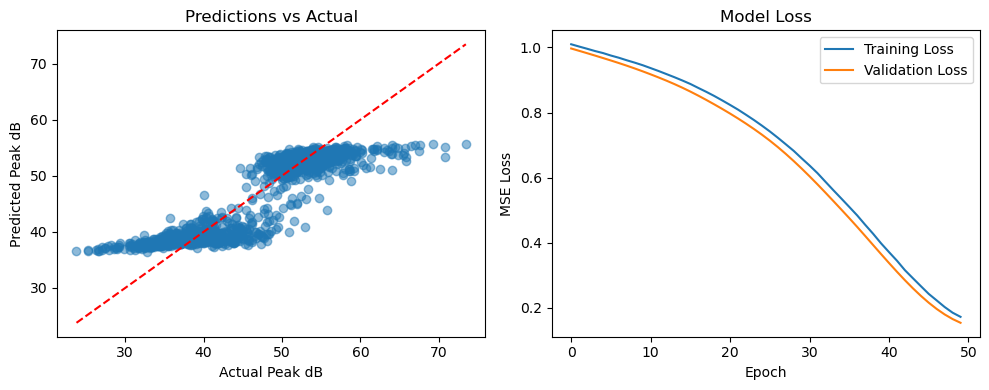

In [222]:
# Plot predictions vs actual
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Peak dB')
plt.ylabel('Predicted Peak dB')
plt.title('Predictions vs Actual')

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.tight_layout()
plt.show()